### 🧩 Imports

Import all the necessary libraries:
- `json` for reading/writing JSON files.
- `pandas` and `numpy` for data manipulation.
- `random` for generating random synthetic data.
- `IsolationForest` from `sklearn` for anomaly detection.
- `joblib` for saving the trained model.

In [11]:
import json
import pandas as pd
import numpy as np
import random
import joblib
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
import seaborn as sns

### 📊 Generate Dataset

Create synthetic "normal" network traffic data to train an anomaly detection model. Each sample includes:

- `src_port`: randomly selected from common service ports.
- `dst_port`: a random high port number.
- `packet_size`: typical packet sizes.
- `duration_ms`: duration of the communication.
- `protocol`: randomly selected between TCP and UDP.

This data is saved to `training_data.json` for future use.

In [12]:
COMMON_PORTS = [80, 443, 22, 8080]

def generate_normal_data():
    return {
        "src_port": random.choice(COMMON_PORTS),
        "dst_port": random.randint(1024, 65535),
        "packet_size": random.randint(100, 1500),
        "duration_ms": random.randint(50, 500),
        "protocol": random.choice(["TCP", "UDP"])
    }

dataset = [generate_normal_data() for _ in range(1000)]

with open("../dataset/training_data.json", "w") as f:
    json.dump(dataset, f, indent=2)


In [13]:
with open("E:/uni/cyberSecurity/project/anomaly-detection-project-rsh/dataset/training_data.json") as f:
    raw_data = json.load(f)

df = pd.DataFrame(raw_data)
display(df)

,src_port,dst_port,packet_size,duration_ms,protocol
0,443,63184,1366,315,TCP
1,443,49061,194,486,UDP
2,8080,20777,504,160,TCP
3,80,6391,550,435,TCP
4,8080,54714,814,343,UDP
...,...,...,...,...,...
995,22,19849,915,188,UDP
996,22,47396,382,500,TCP
997,8080,13212,1207,289,UDP
998,22,28402,189,138,TCP


### 🧼 Preprocessing Function

Machine learning models like Isolation Forest require **numerical input only**. Any categorical variables, such as the `protocol` column (`TCP`, `UDP`), must be converted into numbers.

We handle this with **one-hot encoding**, using `pd.get_dummies`.

#### 🛠️ Preprocessing Steps:

1. **Identify categorical columns**:
   - In our case, the `protocol` column is categorical (`TCP`, `UDP`).

2. **Use `pd.get_dummies`**:
   - This creates a new binary column for each category.
   - For instance:
     ```
     protocol
     ---------
     TCP   →   protocol_UDP = 0
     UDP   →   protocol_UDP = 1
     ```
   - Setting `drop_first=True` prevents multicollinearity by dropping the first category (`TCP` here), as it can be inferred from the others.

3. **Return a DataFrame with all numerical values**:
   - This is ready for model input.

> ✅ This preprocessing is essential to avoid errors during training and ensure the model can learn from categorical variables.

In [15]:
def preprocess_data(df):
    df_encoded = pd.get_dummies(df, columns=['protocol'], drop_first=True)
    numerical_cols = ['src_port', 'dst_port', 'packet_size', 'duration_ms']
    df_encoded[numerical_cols] = df_encoded[numerical_cols].astype(float)

    scaler = StandardScaler()
    df_encoded[numerical_cols] = scaler.fit_transform(df_encoded[numerical_cols])

    joblib.dump(scaler, "scaler.joblib")
    return df_encoded

processed_data = preprocess_data(df)

### 🤖 Train Isolation Forest

The `IsolationForest` algorithm is an unsupervised model used to detect anomalies. It isolates observations by randomly selecting features and splitting values.

- `n_estimators=100`: number of trees in the forest.
- `contamination=0.01`: assumes 1% of the data is anomalous.
- `random_state=42`: ensures reproducibility.

The model is trained on the preprocessed numerical dataset.

In [16]:
model = IsolationForest(n_estimators=100, contamination=0.1, random_state=42)
model.fit(processed_data)

IsolationForest(contamination=0.1, random_state=42)

### 💾 Save Trained Model

Save the trained model using `joblib`, which allows for efficient serialization and deserialization. This saved model can be reused later for inference or deployment.


In [17]:
joblib.dump(model, "anomaly_model.joblib")

['anomaly_model.joblib']

# predict and score data

In [18]:
scores = model.score_samples(processed_data)
predictions = model.predict(processed_data)
print(predictions)

[ 1  1  1  1  1  1  1  1  1  1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1 -1  1  1  1  1  1  1  1 -1  1 -1  1  1  1 -1  1  1  1 -1  1
 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1 -1  1 -1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1 -1 -1  1  1 -1  1  1  1 -1  1  1  1  1  1
  1  1  1  1  1  1  1 -1  1  1  1  1  1 -1  1  1  1  1  1 -1  1  1  1  1
  1  1 -1  1 -1  1  1  1 -1  1  1  1  1  1 -1  1  1  1  1 -1  1  1  1  1
  1  1  1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1 -1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1  1  1 -1  1  1  1 -1
 -1  1  1  1  1  1  1 -1  1  1  1  1  1  1  1  1 -1  1  1  1 -1  1  1  1
  1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1

# Visualize Normal and Anomalous Points with PCA

Number of anomalies detected: 100


,src_port,dst_port,packet_size,duration_ms,protocol,prediction,confidence_score
10,8080,64247,637,182,TCP,-1,0.598339
28,8080,2819,1488,471,TCP,-1,0.651476
36,8080,58421,209,347,UDP,-1,0.595837
38,8080,8491,1318,68,TCP,-1,0.618472
42,443,62539,1245,58,UDP,-1,0.587925


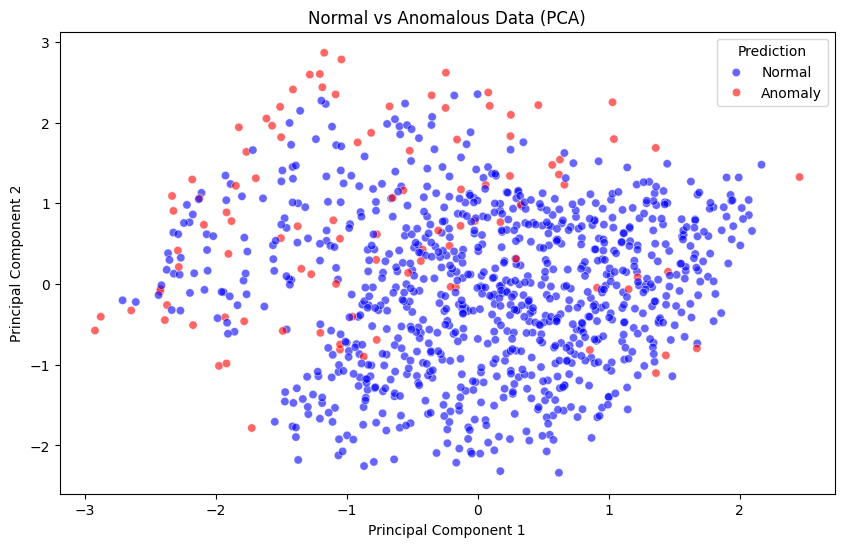

Explained variance ratio by PCA: [0.25462669 0.24022883]


In [19]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# anomalies
df['prediction'] = predictions
df['confidence_score'] = -scores
anomalies = df[df['prediction'] == -1]
anomalies.to_csv("anomalies_detected.csv", index=False)
print(f"Number of anomalies detected: {len(anomalies)}")
display(anomalies.head())

# Apply PCA
pca = PCA(n_components=2)
pca_data = pca.fit_transform(processed_data)

pca_df = pd.DataFrame(data=pca_data, columns=['PC1', 'PC2'])
pca_df['prediction'] = predictions

# Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='prediction', palette={1: 'blue', -1: 'red'}, alpha=0.6)
plt.title('Normal vs Anomalous Data (PCA)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Prediction', labels=['Normal', 'Anomaly'])
plt.show()

print(f"Explained variance ratio by PCA: {pca.explained_variance_ratio_}")

This code:
    
    Generates sample anomalous data.
    Combines it with normal data.
    Uses PCA to reduce to 2D.
    Plots normal (blue) and anomalous (red) points.